## Logistic regression

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression

from utils import * ### need utils.py in the same folder as this notebook

idx = pd.IndexSlice
pd.set_option('max.rows', 100)
pd.set_option('max.columns', 300)
pd.set_option('mode.chained_assignment', 'raise')
pd.set_option('display.float_format', lambda x: '%.4f' % x) #supress scientific notation

In [3]:

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
# generating data set
rnd = np.random.RandomState(1729)
max_num = 10000000

dict_split = {'train': [(3, 150)], ## COVID only
             'val': [(3, 30)], ## COVID only
             'test': [(1, 1000), (2, 100), (3, 30)] ## ILI, Flu, COVID
             }
df_activity = pd.concat([generate_normalized_hr_sample(i, split, ili) for split,v in dict_split.items() 
                         for ili,n in v 
                         for i in rnd.choice(np.arange(1,max_num), n)
                        ])
print(df_activity.shape)
print('N =', count_unique_index(df_activity))
assert count_unique_index(df_activity) == df_activity.shape[0]/43
describe_datetimeindex(df_activity)

(56330, 24)
N = 1310


count                            56330
mean     2020-04-07 18:06:02.748091392
min                2020-01-04 00:00:00
25%                2020-02-29 00:00:00
50%                2020-04-07 00:00:00
75%                2020-05-17 00:00:00
max                2020-07-11 00:00:00
Name: dt, dtype: object

The number of participants should match total rows by 43

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
#prop_table(df_activity['labels', 'split'])

In [6]:
label_col = ('labels', 'training_labels')
split_col = ('labels', 'split')
type_col = ('labels', 'ILI_type')

days_ago = ['0days_ago', '1days_ago', '2days_ago', '3days_ago', '4days_ago']
feature_cols = ['heart_rate__not_moving__max', 
                'heart_rate__resting_heart_rate',
                'heart_rate__stddev',
                'heart_rate__perc_50th']

flag = ('0days_ago', 'heart_rate__not_moving__max') #trim NaN

# get training data
keep_train = (df_activity[label_col].isin([0,1]) 
                & (df_activity[split_col] == 'train')
                & (df_activity[type_col] == 3)
                & (df_activity[flag].notna())
               )

X_train, y_train, filter_train = get_dataset(df_activity, keep_train, days_ago, feature_cols, label_col)

# get validation data
keep_val = (df_activity[label_col].isin([0,1]) 
            & (df_activity[split_col] == 'val')
            & (df_activity[type_col] == 3)
            & (df_activity[flag].notna())
             )

X_val, y_val, filter_val = get_dataset(df_activity, keep_val, days_ago, feature_cols, label_col)

(2690, 20) (2690,)
Missing rows percent = 0.00%
  (labels, training_labels)  count  percent
0                         0   1894  70.4100
1                         1    796  29.5900
2                     Total   2690 100.0000
(539, 20) (539,)
Missing rows percent = 0.00%
  (labels, training_labels)  count  percent
0                         0    385  71.4300
1                         1    154  28.5700
2                     Total    539 100.0000


### Train classifier with default hyperparameters -- to check

In [7]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
scorer = roc_auc_score

yh_train = classifier.predict_proba(X_train)[:,1]
yh_val = classifier.predict_proba(X_val)[:,1]
    
print(f'Train ROC: {scorer(y_train, yh_train):.4f}')
print(f'Val ROC: {scorer(0+(y_val > 0), yh_val):.4f}')    
print(classifier.coef_)
print(classifier.score)

Train ROC: 0.8058
Val ROC: 0.8325
[[-0.31142474  0.20971667 -0.4298095  -0.40623048 -0.31142474  0.20971667
  -0.4298095  -0.40623048 -0.31142474  0.20971667 -0.4298095  -0.40623048
  -0.31142474  0.20971667 -0.4298095  -0.40623048 -0.31142474  0.20971667
  -0.4298095  -0.40623048]]
<bound method ClassifierMixin.score of LogisticRegression()>


In [8]:
keep_test  = (
             (df_activity[split_col] == 'test')
            & (df_activity[flag].notna())
             )

X_test, y_test, filter_test = get_dataset(df_activity, keep_test, days_ago, feature_cols, label_col)

(42141, 20) (42141,)
Missing rows percent = 0.00%
  (labels, training_labels)  count  percent
0                        -1  21189  50.2800
1                         0  14262  33.8400
2                         1   6690  15.8800
3                     Total  42141 100.0000


In [9]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [10]:
#from sklearn.linear_model import LogisticRegressionCV
grid={"C":np.logspace(-3,3,10)}# l1 lasso l2 ridge
clf=LogisticRegression()
clf_cv=GridSearchCV(clf,grid,cv=10)
clf_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",clf_cv.best_params_)
print("accuracy :",clf_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1}
accuracy : 0.8193308550185874


In [11]:
c = LogisticRegression(C =0.1)
classifier.fit(X_train, y_train)
scorer = roc_auc_score

yh_train = classifier.predict_proba(X_train)[:,1]
yh_val = classifier.predict_proba(X_val)[:,1]
    
print(f'Train ROC: {scorer(y_train, yh_train):.4f}')
print(f'Val ROC: {scorer(0+(y_val > 0), yh_val):.4f}') 

Train ROC: 0.8058
Val ROC: 0.8325


In [12]:
yh_val = classifier.predict_proba(X_val)
ROC_HvC_val, spec_thresh_HvC_val = get_specificity_threshold(y_val[filter_val],
                                                         yh_val[filter_val,1],
                                                         [0.95, 0.9]
                                                        )

95% Specifivity cutoff = 0.5146
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       385
           1       0.85      0.58      0.69       154

    accuracy                           0.85       539
   macro avg       0.85      0.77      0.79       539
weighted avg       0.85      0.85      0.84       539

--------------------------------------------------
90% Specifivity cutoff = 0.4205
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       385
           1       0.72      0.65      0.68       154

    accuracy                           0.83       539
   macro avg       0.79      0.78      0.78       539
weighted avg       0.83      0.83      0.83       539

--------------------------------------------------


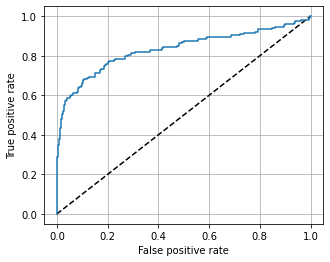

In [13]:
plot_roc(ROC_HvC_val[0], ROC_HvC_val[1])


In [14]:
from diffprivlib.models import LogisticRegression

In [15]:
clf = LogisticRegression( epsilon=2)
clf.fit(X_train, y_train)


C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


LogisticRegression(accountant=BudgetAccountant(spent_budget=[(2, 0)]),
                   data_norm=5.404197434264177, epsilon=2)

In [16]:
clf.score(X_train, y_train)

yh_train = clf.predict_proba(X_train)[:,1]
yh_val = clf.predict_proba(X_val)[:,1]
    
print(f'Train ROC: {scorer(y_train, yh_train):.4f}')
print(f'Val ROC: {scorer(0+(y_val > 0), yh_val):.4f}')   

Train ROC: 0.7836
Val ROC: 0.7937


In [17]:
dp_clf = LogisticRegression(epsilon=float("inf"))
dp_clf.fit(X_train, y_train)
yh_train = dp_clf.predict_proba(X_train)[:,1]
yh_val = dp_clf.predict_proba(X_val)[:,1]
    
print(f'Train ROC: {scorer(y_train, yh_train):.4f}')
print(f'Val ROC: {scorer(0+(y_val > 0), yh_val):.4f}')  

Train ROC: 0.8058
Val ROC: 0.8325


C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


In [39]:
roc = []
epsilons = [0.0001, 0.0005, 0.001,0.005, 0.01,0.05, 0.1,0.5, 1, 2, 4, 8]
y_error = []

for e in epsilons:
    res = []
    for _ in range(50):
        clf = LogisticRegression(epsilon=e).fit(X_train, y_train)
        yh_val = clf.predict_proba(X_val)[:,1]
        res.append(scorer(0+(y_val > 0), yh_val))
    y_error.append(np.std(res))
    roc.append(np.mean(res))
    

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\dell\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWa

In [40]:
print(y_error)
print(roc)

[0.19157283163184274, 0.17606897404550553, 0.19044118116815378, 0.19685676193805438, 0.20523019089495836, 0.18175926841779086, 0.1511605162139275, 0.05366088984373342, 0.016748240551034452, 0.006460526103968571, 0.00494459358352335, 0.0009916449486658367]
[0.5383911283521673, 0.4569806038117727, 0.46906392308989714, 0.5025326361949738, 0.5112410187215383, 0.5495667060212516, 0.6115469725080114, 0.7666405801990218, 0.8154258728284702, 0.8273604317760161, 0.829497385731152, 0.8320199021757465]


In [41]:
baseline = 0.8325

import pickle

pickle.dump((epsilons, baseline, roc, y_error), open("lr_roc_50.p", "wb" ) )

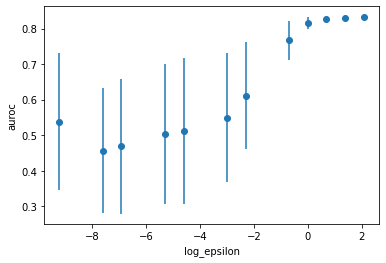

In [43]:
epsilons, baseline, roc, y_error = pickle.load(open("lr_roc_50.p", "rb"))

plt.errorbar(np.log(epsilons), roc, y_error,fmt='o')
plt.xlabel("log_epsilon")
plt.ylabel("auroc")
plt.show()